In [1]:
import scanpy
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [2]:
sc.settings.verbosity = 0
import warnings
warnings.filterwarnings("ignore")

In [3]:
sc.settings.set_figure_params(dpi=100, fontsize=12, dpi_save=300, figsize=(6, 6))

In [9]:
adata = scanpy.read_h5ad("your_file_path/in_data.h5ad") #laod the data from your file path

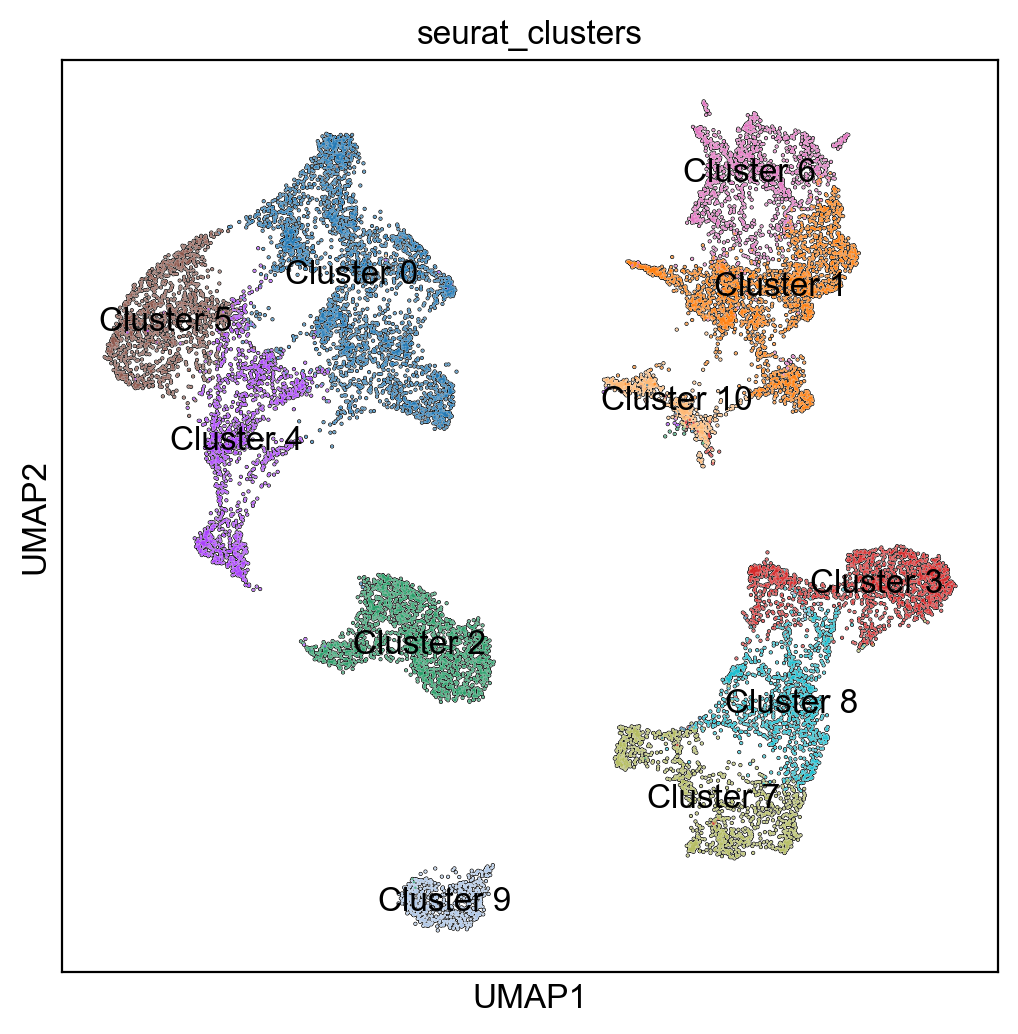

In [17]:
sc.pl.umap(adata, color = ['seurat_clusters'], frameon = True, s=3, add_outline = True,  show=False, legend_loc = 'on data',legend_fontweight = 'normal',)
#plt.savefig("your_file_path/inhibitory_clusters", dpi=600, bbox_inches='tight', format='pdf')
plt.show()

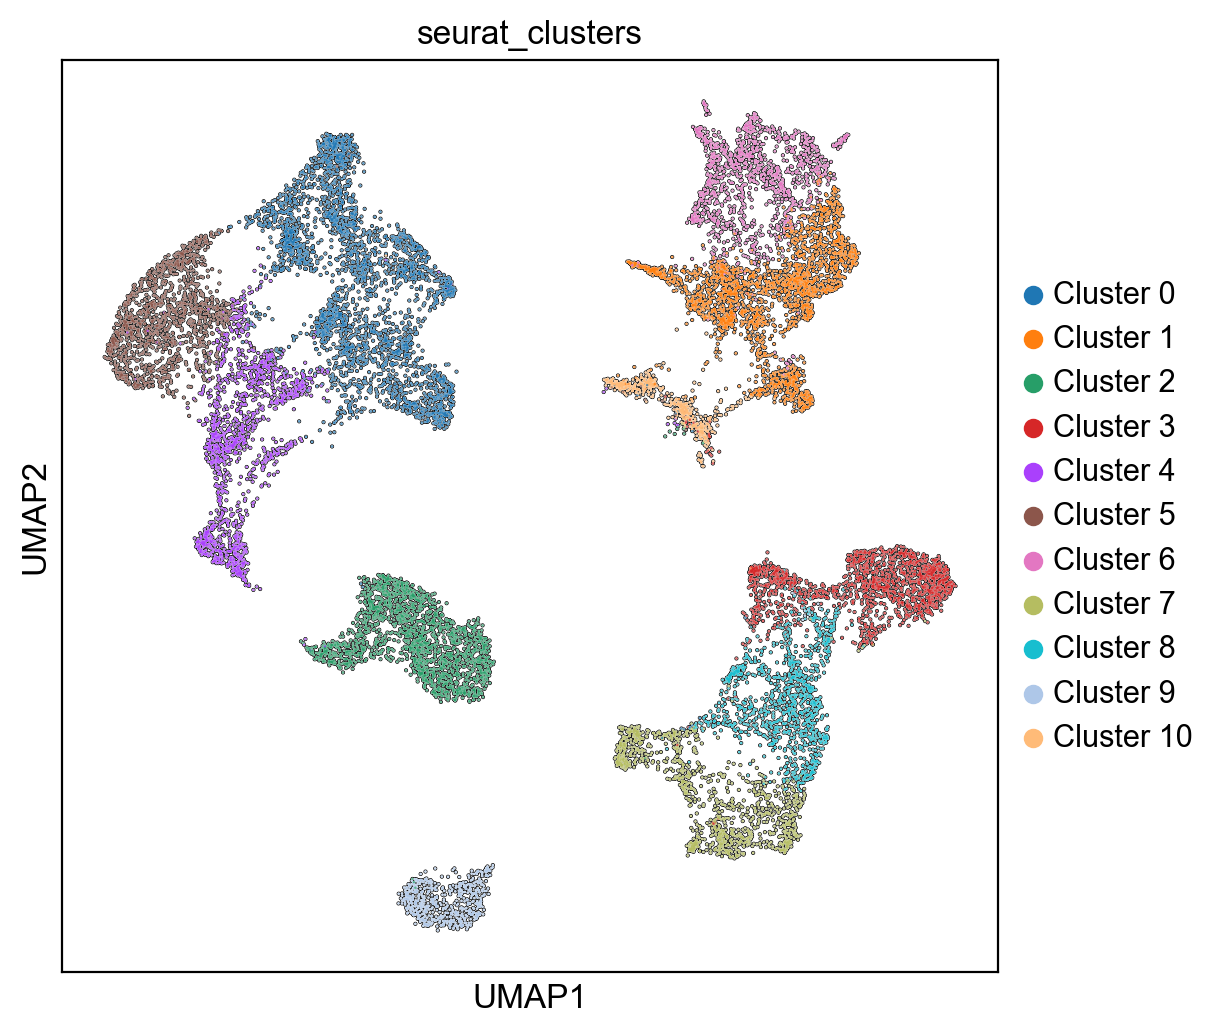

In [18]:
sc.pl.umap(adata, color = ['seurat_clusters'], frameon = True, s=3, add_outline = True,  show=False)
#plt.savefig("your_file_path/inhibitory_clusters1", dpi=600, bbox_inches='tight', format='pdf')
plt.show()

In [14]:
haris_LINNARSSON_zeng_reordered1 =  ['Sst', 'Meis2',  'Lamp5',  'Nos1','Vip', 'Calb2', 'ENSRNOG00000006471', 'Cck', 'Calb1'] # Note: ENSRNOG00000006471 is Pvalb

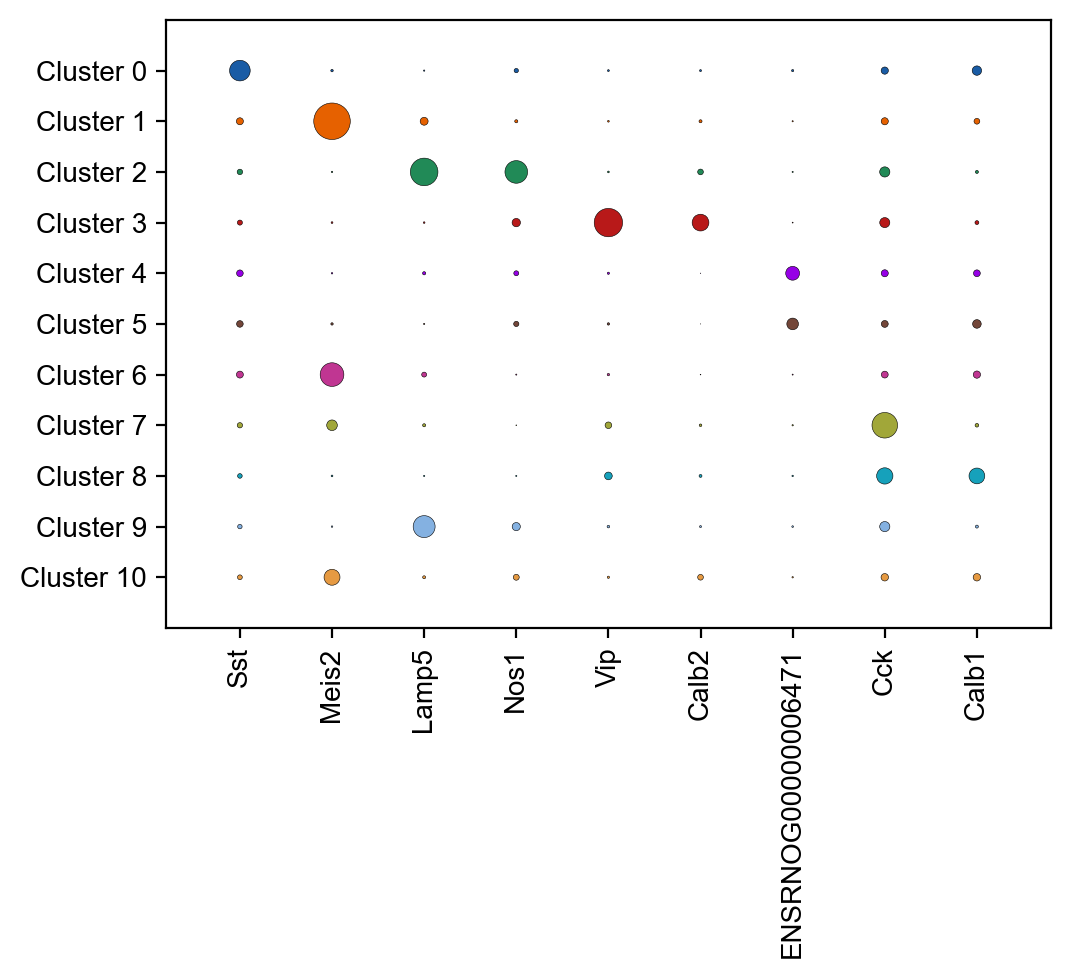

In [16]:
from matplotlib.colors import ListedColormap

# Define colors for each hex_subregion
seurat_clusters_color = {
    "Cluster 0": "#1a5ca5",  # Darker, more saturated blue
    "Cluster 1": "#e66100",  # Richer, more saturated orange
    "Cluster 2": "#218a57",  # Darker, more saturated green
    "Cluster 3": "#b81919",  # Richer red
    "Cluster 4": "#9600e6",  # Darker, more intense purple
    "Cluster 5": "#734639",  # Deeper, more saturated brown
    "Cluster 6": "#c03692",  # Richer pinkish-purple
    "Cluster 7": "#a1a739",  # Deeper, more saturated yellow-green
    "Cluster 8": "#16a1bb",  # Richer cyan
    "Cluster 9": "#84b1e1",  # More vivid light blue
    "Cluster 10": "#e69a42",  # Darker, more saturated peach
}


# Convert cell type colors to a color map
unique_colors = list(seurat_clusters_color.values())
cmap = ListedColormap(unique_colors)

dp = sc.pl.DotPlot(adata, haris_LINNARSSON_zeng_reordered1, groupby='seurat_clusters', figsize=(6, 4), standard_scale="var").style(
    dot_edge_color='black',
    dot_edge_lw=0.1
).legend(show=False)

#expression_cutoff = 0.25

# Map cell types to integers for color display
color_mapping = {Seurat_clusters: idx for idx, Seurat_clusters in enumerate(seurat_clusters_color.keys())}
for Seurat_clusters, idx in color_mapping.items():
    if Seurat_clusters in dp.dot_color_df.index:
        dp.dot_color_df.loc[Seurat_clusters, :] = idx

# Set the custom colormap
dp.style(cmap=cmap)
#dp.savefig("your_file_path/inhibitory_dotplot", dpi=600, bbox_inches='tight', format='pdf')
dp.show()

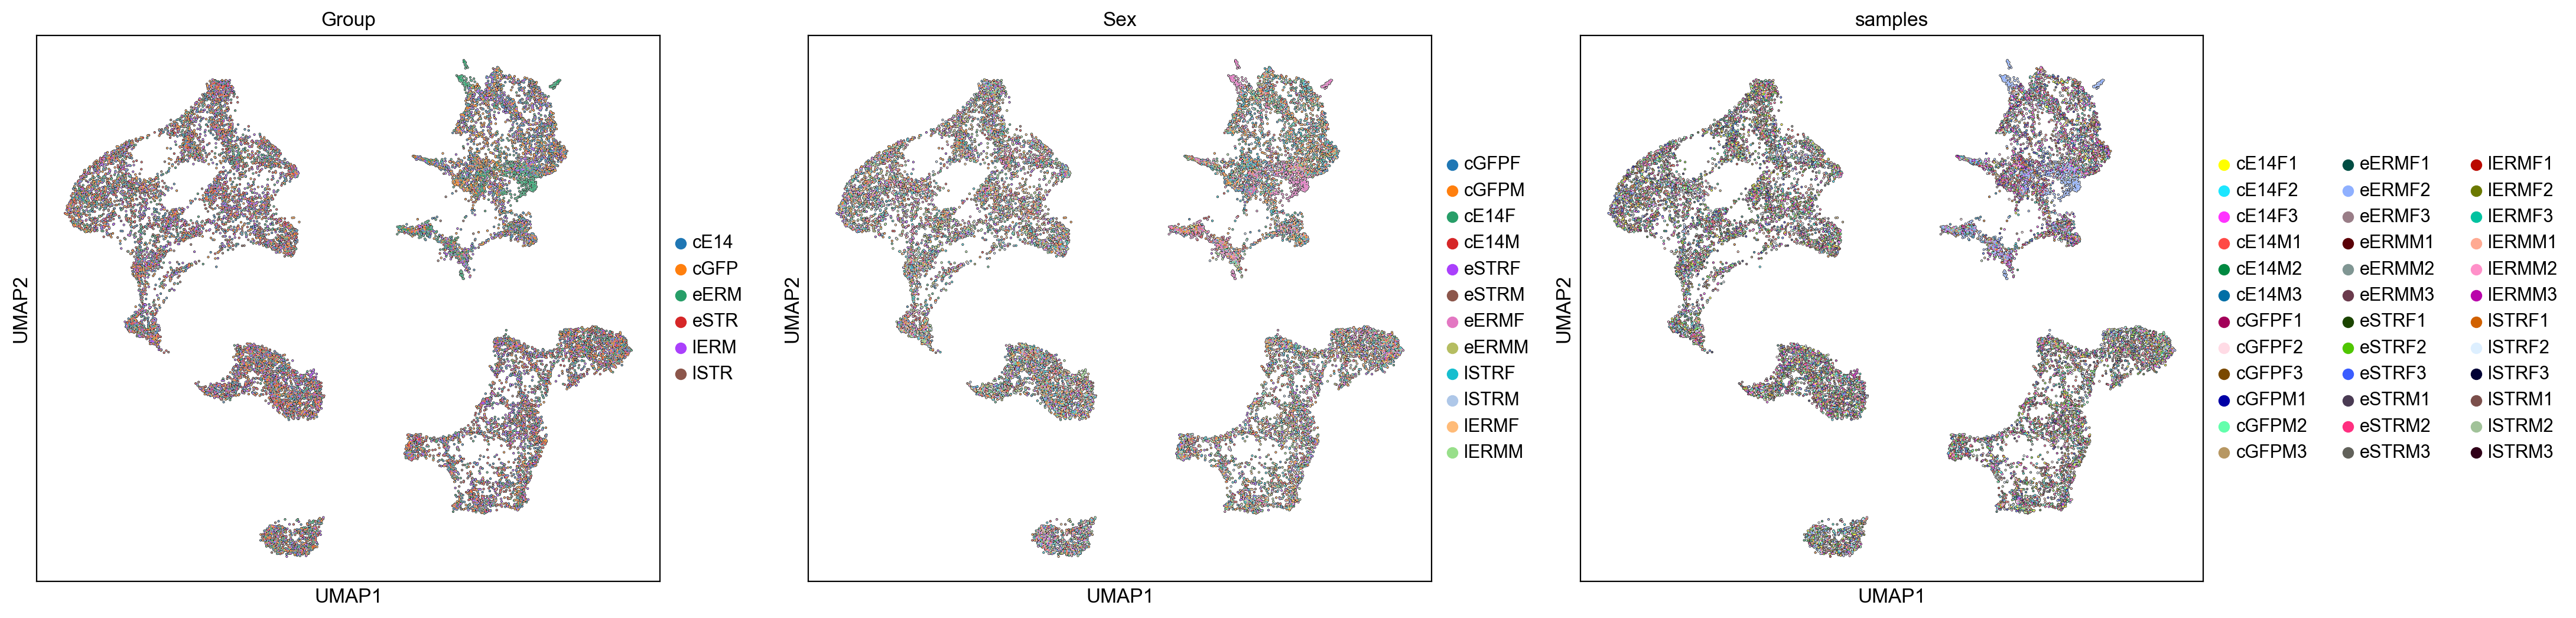

In [19]:
from matplotlib.pyplot import rc_context

with rc_context({"figure.figsize": (7, 6)}):
    sc.pl.umap(adata, color = ['Group', 'Sex','samples'], frameon = True, s=3, add_outline = True, show=False)
plt.tight_layout()
plt.show()


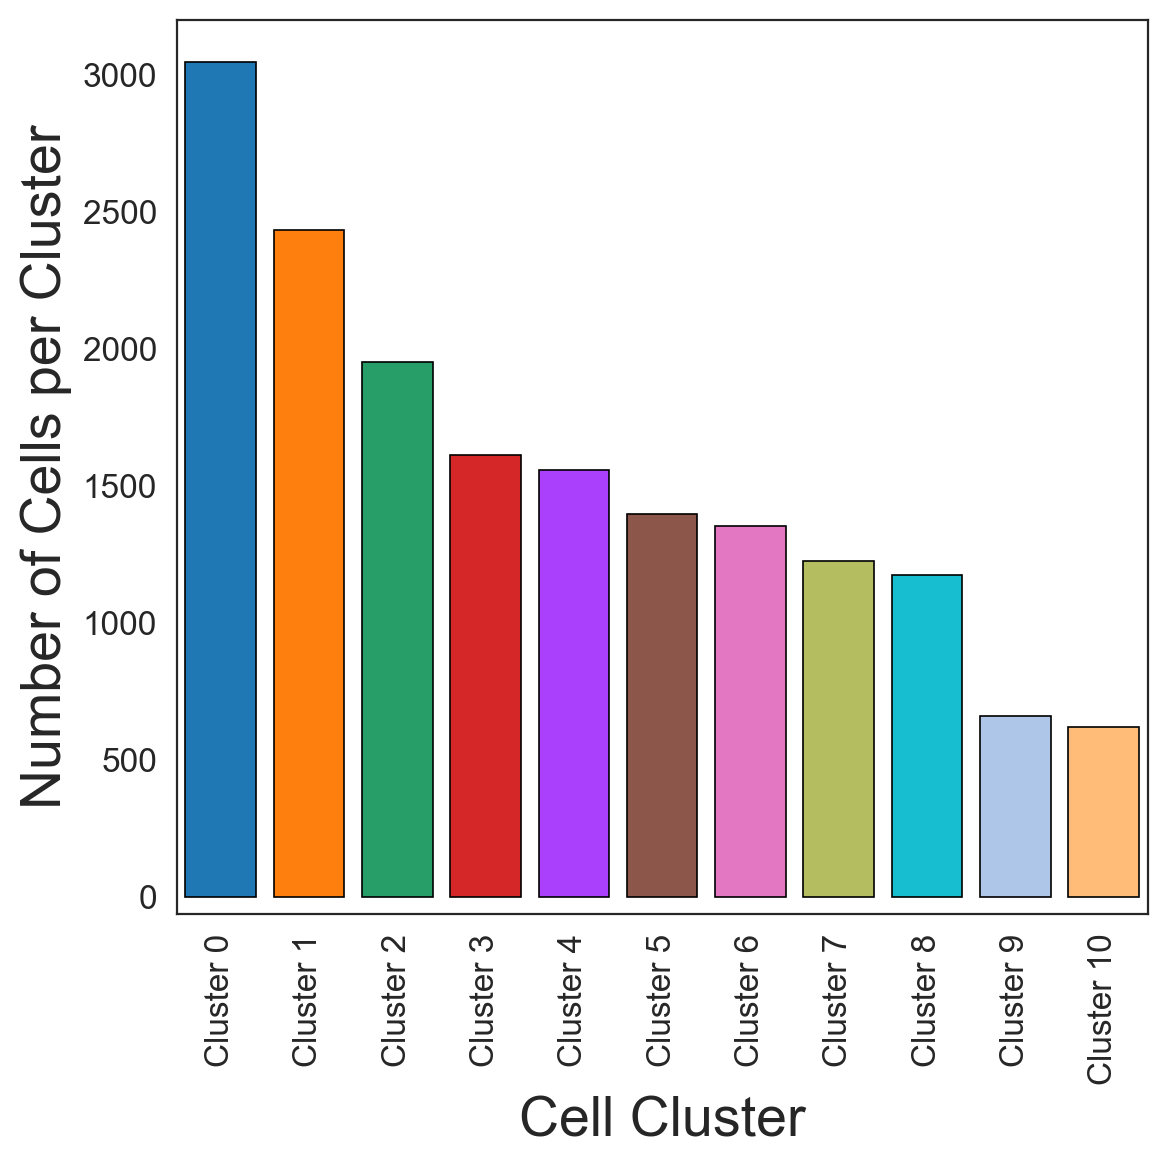

In [20]:
# Calculate and sort cluster counts in descending order
cluster_counts = adata.obs['seurat_clusters'].value_counts()
#cluster_counts = cluster_counts.sort_values(ascending=False)

seurat_clusters_colors = adata.uns['seurat_clusters_colors']

sns.set_style("white")
plt.figure(figsize=(6, 6))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, edgecolor='black', linewidth=0.6, saturation = 1)

ax.tick_params(axis='x', labelsize=12, rotation=90)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Cell Cluster', fontsize=20)
ax.set_ylabel('Number of Cells per Cluster', fontsize=20)
ax.set_ylim(bottom=-max(cluster_counts.values)*0.02)  # float bars above x-axis
#ax.set_title('Number of Cells per Cluster', fontsize=20)
plt.tight_layout()

#dp.savefig("your_file_path/inhibitory_cluster_count", dpi=600, bbox_inches='tight', format='pdf')
dp.show()

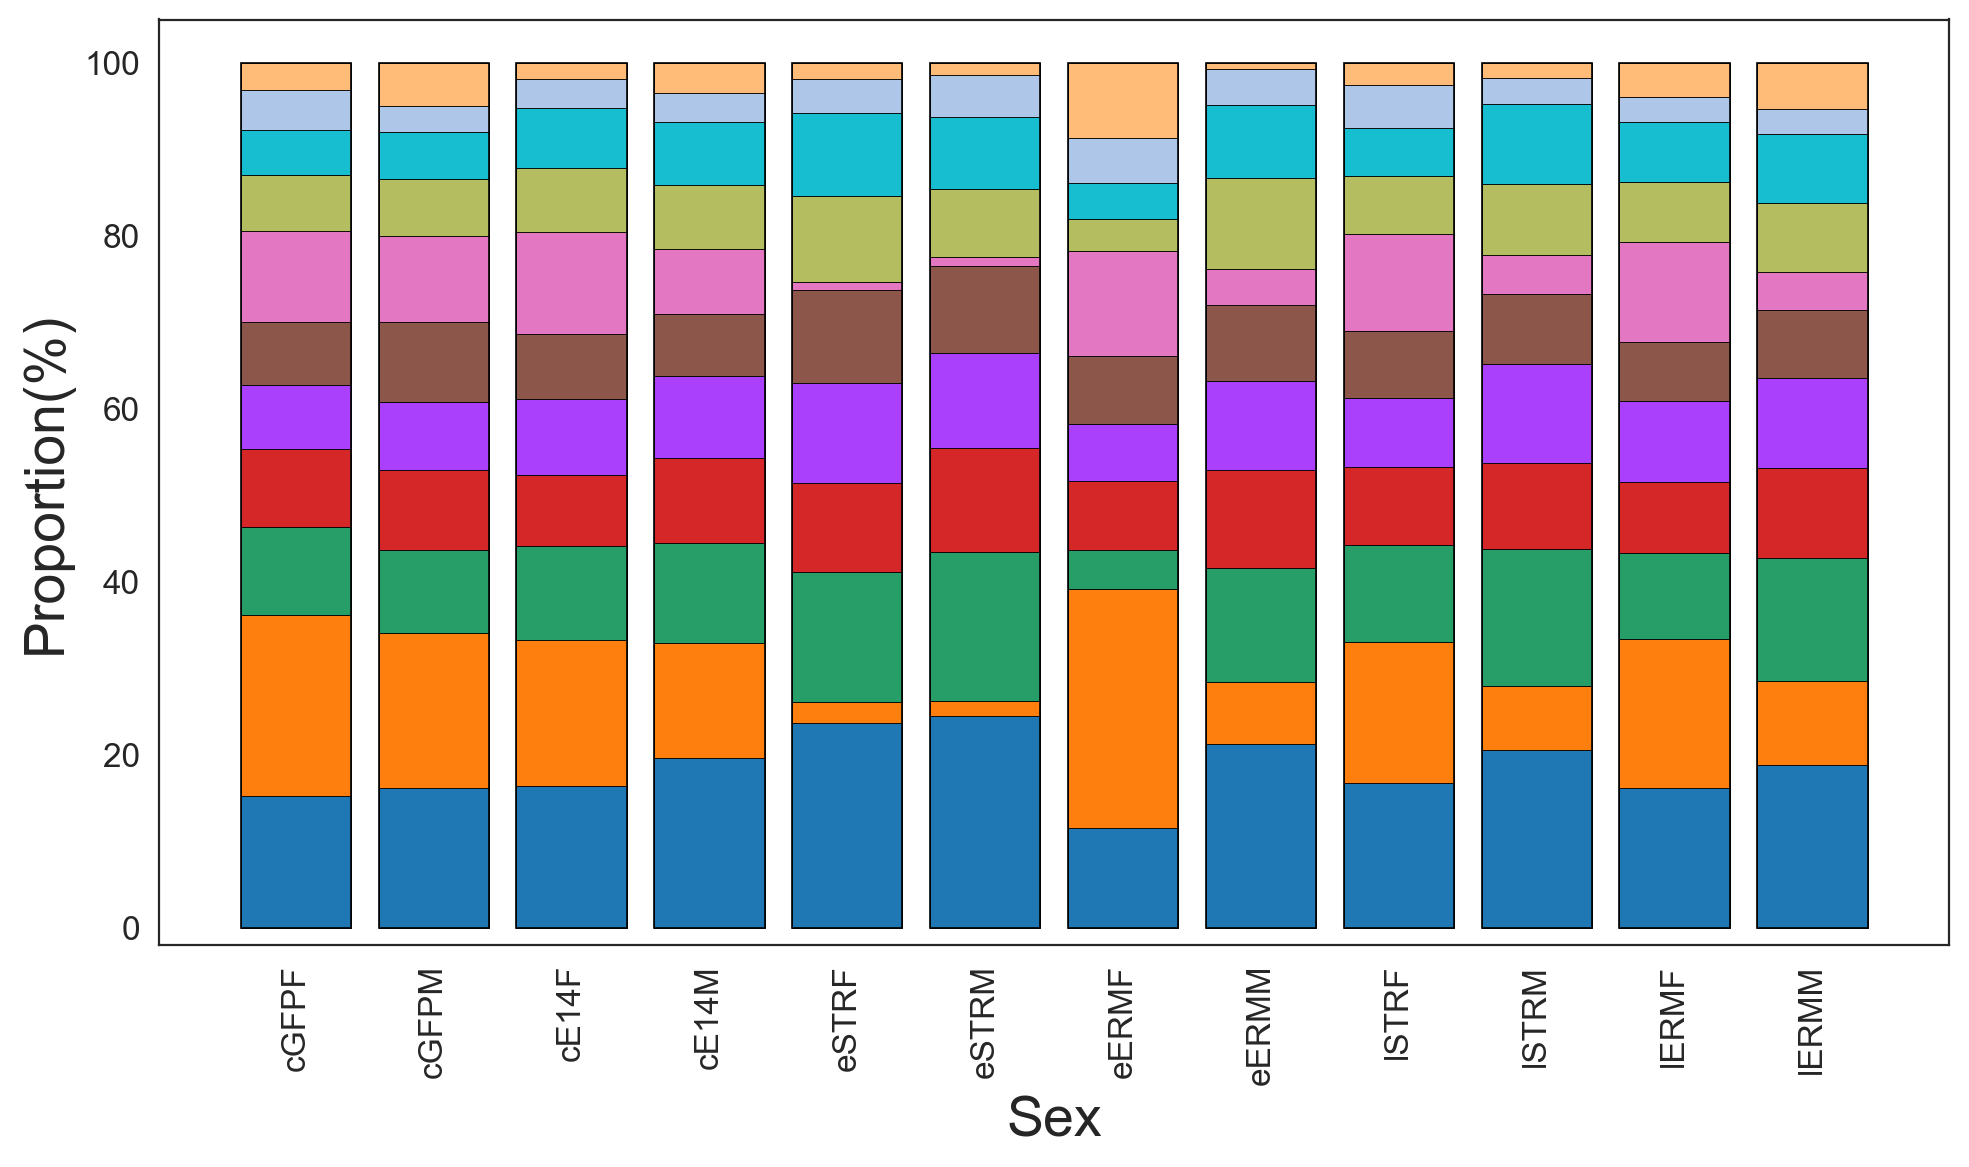

In [21]:
# Count cells per Sex and cluster
cell_counts = (
    adata.obs.groupby(['Sex','seurat_clusters'])
    .size()
    .reset_index(name='count')
)

# Normalize within each Sex
cell_counts['proportion'] = cell_counts.groupby('Sex')['count'].transform(
    lambda x: x / x.sum() * 100
)

# Pivot to wide format
df = cell_counts.pivot(
    index='Sex', 
    columns='seurat_clusters', 
    values='proportion'
).fillna(0)

# Reorder Sex rows
desired_order = [
    'cGFPF','cGFPM','cE14F','cE14M',
    'eSTRF','eSTRM','eERMF','eERMM',
    'lSTRF','lSTRM','lERMF','lERMM'
]
df = df.loc[desired_order]

# --- Use Scanpy's cluster colors ---
cluster_categories = adata.obs['seurat_clusters'].cat.categories
colors = dict(zip(cluster_categories, adata.uns['seurat_clusters_colors']))

# Build color list in same order as df.columns
bar_colors = [colors[ct] for ct in df.columns]

# --- Plot ---
plt.figure(figsize=(10, 6))
width = 0.8
x = range(len(df.index))

for i, cluster in enumerate(df.columns):
    plt.bar(
        x,
        df[cluster],
        width=width,
        bottom=df.iloc[:, :i].sum(axis=1) if i > 0 else None,
        color=bar_colors[i],
        edgecolor='black',
        linewidth=0.3,
        label=f"Cluster {cluster}"
    )

plt.bar(
    x,
    df.sum(axis=1),
    width=width,
    facecolor='none',
    edgecolor='black',
    linewidth=0.6
)

plt.xticks(ticks=x, labels=df.index, rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Sex', fontsize=20)
plt.ylabel('Proportion(%)', fontsize=20)

ax = plt.gca()
ax.grid(False)
ymax = df.to_numpy().sum(axis=1).max()
ax.set_ylim(bottom=-ymax*0.02)

plt.tight_layout()
plt.show()
